# PMF–ALS Experiment: Testing Subspace Invariance Theory

## Core Theoretical Claim

**When ALS is initialized in the subspace spanned by specific singular vectors of Y, it will:**
1. **Stay in that subspace** (subspace invariance)
2. **Converge to the stationary point** obtained by soft-thresholding the corresponding singular values

## Mathematical Setup

- **MAP Objective:** $L(U,V) = \frac{1}{2}\|Y - UV^\top\|_F^2 + \frac{1}{2}(\text{tr}(U^\top \Lambda U) + \text{tr}(V^\top \Lambda V))$
- **Global Minimizer:** $U^* = F_R \text{diag}\big(\sqrt{(\sigma_i - \lambda_i)_+}\big)$, $V^* = G_R \text{diag}\big(\sqrt{(\sigma_i - \lambda_i)_+}\big)$, where $\lambda_i = \Lambda_{ii}$
- **Soft-thresholding:** $(x)_+ = \max(x,0)$
- **Precision Matrix:** $\Lambda = \text{diag}(\lambda_1, \lambda_2, \ldots, \lambda_R)$ is a diagonal regularization matrix

## 1. Setup: Parameters and Data Generation

In [139]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

# Fixed seed for reproducibility
seed = 42
np.random.seed(seed)

# === EXPERIMENT PARAMETERS ===
# Matrix dimensions (smaller for clarity)
m, n = 100, 80
true_rank = 10

# Clean integer singular values (hardcoded for interpretability)
# add some noise to singular values
singular_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# ALS parameters
R = 3                  # Latent factorization rank
# Define diagonal precision matrix Lambda (can adjust individual entries)
Lambda = np.diag([5, 5, 5])  # Diagonal regularization matrix of size R x R

# Stationary points selection
top_indices = [0, 1, 2]        # Top 3 singular vectors
alt_indices = [5, 6, 7]        # Alternative 3 singular vectors

print("=== EXPERIMENT SETUP ===")
print(f"Matrix size: {m} × {n}")
print(f"Singular values: {singular_values}")
print(f"Regularization Λ = diag{np.diag(Lambda).tolist()}")
print(f"Latent rank R = {R}")
print(f"Top subspace indices: {top_indices}")
print(f"Alt subspace indices: {alt_indices}")

=== EXPERIMENT SETUP ===
Matrix size: 100 × 80
Singular values: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Regularization Λ = diag[5, 5, 5]
Latent rank R = 3
Top subspace indices: [0, 1, 2]
Alt subspace indices: [5, 6, 7]


In [140]:
# Generate synthetic matrix with known structure
# Y = U_true * S_true * V_true^T
U_true, _ = np.linalg.qr(np.random.randn(m, true_rank))
V_true, _ = np.linalg.qr(np.random.randn(n, true_rank))
Y_true = U_true @ np.diag(singular_values) @ V_true.T

# add noise
noise_level = 0.1
Y = Y_true + noise_level * np.random.randn(m, n)

# Compute SVD of Y (should recover our structure)
U_svd, s_svd, Vt_svd = npl.svd(Y, full_matrices=False)
V_svd = Vt_svd.T

print("\n=== DATA GENERATION VERIFICATION ===")
print(f"Y shape: {Y.shape}")
print(f"Recovered singular values: {s_svd[:true_rank].round(6)}")
print(f"Expected singular values:  {singular_values}")
print(f"Match: {np.allclose(s_svd[:true_rank], singular_values)}")


=== DATA GENERATION VERIFICATION ===
Y shape: (100, 80)
Recovered singular values: [10.05959   9.119216  8.108382  7.272851  6.186656  5.285376  4.182003
  3.313041  2.376467  1.81008 ]
Expected singular values:  [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Match: False


## 2. Theory: Expected Solutions via Soft-Thresholding

In [141]:
def soft_threshold(sigma, lam_vec):
    """Apply soft-thresholding: max(sigma - lambda_i, 0) element-wise"""
    return np.maximum(sigma - lam_vec, 0.0)

def compute_map_solution(U_svd_subset, V_svd_subset, sigma_subset, lam_vec):
    """Compute MAP solution U*, V* for given subspace
    lam_vec should be the diagonal entries of Lambda for this subspace"""
    # Apply soft-thresholding to get target scalings
    target_scales = np.sqrt(soft_threshold(sigma_subset, lam_vec))
    
    # Form MAP solution matrices
    U_target = U_svd_subset @ np.diag(target_scales)
    V_target = V_svd_subset @ np.diag(target_scales)
    
    return U_target, V_target, target_scales


### Compute the theoretical MAP solutions

In [142]:
# Extract singular vectors and values for the two stationary points (top and alt)
U_svd_top = U_svd[:, top_indices]
V_svd_top = V_svd[:, top_indices] 
sigma_top = s_svd[top_indices]

U_svd_alt = U_svd[:, alt_indices]
V_svd_alt = V_svd[:, alt_indices]
sigma_alt = s_svd[alt_indices]

# Compute theoretical MAP solutions
U_target_top, V_target_top, scales_top = compute_map_solution(U_svd_top, V_svd_top, sigma_top, np.diag(Lambda))
U_target_alt, V_target_alt, scales_alt = compute_map_solution(U_svd_alt, V_svd_alt, sigma_alt, np.diag(Lambda))

print("=== SOFT-THRESHOLDING ANALYSIS ===")
print(f"Regularization Λ = diag{np.diag(Lambda).tolist()}") 
print()
print(f"Top subspace (indices {top_indices}):")
print(f"  Singular values: {sigma_top.round(2)}")
print(f"  After thresholding: {soft_threshold(sigma_top, np.diag(Lambda)).round(2)}")
print(f"  Target scales: {scales_top.round(3)}")
print()
print(f"Alt subspace (indices {alt_indices}):")
print(f"  Singular values: {sigma_alt.round(2)}")
print(f"  After thresholding: {soft_threshold(sigma_alt, np.diag(Lambda)).round(2)}")
print(f"  Target scales: {scales_alt.round(3)}")

=== SOFT-THRESHOLDING ANALYSIS ===
Regularization Λ = diag[5, 5, 5]

Top subspace (indices [0, 1, 2]):
  Singular values: [10.06  9.12  8.11]
  After thresholding: [5.06 4.12 3.11]
  Target scales: [2.249 2.03  1.763]

Alt subspace (indices [5, 6, 7]):
  Singular values: [5.29 4.18 3.31]
  After thresholding: [0.29 0.   0.  ]
  Target scales: [0.534 0.    0.   ]


## 3. Initialize: Set ALS Starting Points

In [143]:
def initialize_in_subspace(U_svd_subset, V_svd_subset, scale_range=(0.1, 10.0)):
    """Initialize U0, V0 in given subspace with random scalings"""
    R = U_svd_subset.shape[1]
    
    # Random scaling factors
    scales_U = np.random.uniform(scale_range[0], scale_range[1], R)
    scales_V = np.random.uniform(scale_range[0], scale_range[1], R)
    
    # Initialize in subspace with random scalings
    U0 = U_svd_subset @ np.diag(scales_U)
    V0 = V_svd_subset @ np.diag(scales_V)
    
    return U0, V0, scales_V

# Initialize ALS starting points in each subspace
U0_top, V0_top, init_scales_V_top = initialize_in_subspace(U_svd_top, V_svd_top)
U0_alt, V0_alt, init_scales_V_alt = initialize_in_subspace(U_svd_alt, V_svd_alt)

print("=== INITIALIZATION ===")
# print(f"Top subspace - Initial U scales: {init_scales_U_top.round(2)}")
print(f"Top subspace - Initial V scales: {init_scales_V_top.round(2)}")
# print(f"Alt subspace - Initial U scales: {init_scales_U_alt.round(2)}")
print(f"Alt subspace - Initial V scales: {init_scales_V_alt.round(2)}")
print()
print("Key insight: ALS should adjust these random scalings to the optimal target scales!")

=== INITIALIZATION ===
Top subspace - Initial V scales: [5.98 2.75 6.49]
Alt subspace - Initial V scales: [5.67 2.6  9.55]

Key insight: ALS should adjust these random scalings to the optimal target scales!


## 4. Run: Execute ALS Algorithm

In [144]:
def als_algorithm(Y, V0, Lambda, max_iterations=100, tolerance=1e-7, verbose=True):
    """Run ALS algorithm with convergence tracking"""
    V = V0.copy()
    obj_prev = np.inf
    loss_history = []  # Track loss at each iteration
    
    for iteration in range(max_iterations):
        # ALS updates
        VtV_reg = V.T @ V + Lambda
        U = Y @ V @ npl.inv(VtV_reg)
        
        UtU_reg = U.T @ U + Lambda
        V = Y.T @ U @ npl.inv(UtU_reg)
        
        # Compute objective
        residual = Y - U @ V.T
        obj = 0.5 * np.sum(residual**2) + 0.5 * (np.trace(U @ Lambda @ U.T) + np.trace(V @ Lambda @ V.T))
        loss_history.append(obj)  # Store loss
        
        # Check convergence
        rel_change = abs(obj_prev - obj) / max(1.0, obj_prev)
        if rel_change < tolerance:
            if verbose:
                print(f"  Converged after {iteration + 1} iterations (rel_change: {rel_change:.2e})")
            break
        
        obj_prev = obj
    
    return U, V, obj, iteration + 1, loss_history

print("=== RUNNING ALS ===")
print("Top subspace:")
U_result_top, V_result_top, obj_top, iters_top, loss_hist_top = als_algorithm(Y, V0_top, Lambda)

print("\nAlt subspace:")
U_result_alt, V_result_alt, obj_alt, iters_alt, loss_hist_alt = als_algorithm(Y, V0_alt, Lambda)

print(f"\nFinal objectives:")
print(f"  Top subspace: {obj_top:.6f}")
print(f"  Alt subspace: {obj_alt:.6f}")


=== RUNNING ALS ===
Top subspace:
  Converged after 5 iterations (rel_change: 2.78e-09)

Alt subspace:
  Converged after 16 iterations (rel_change: 6.09e-08)

Final objectives:
  Top subspace: 208.361412
  Alt subspace: 234.435425


/var/folders/d2/m1r5k9xs77n9kj281b15qkgw0000gn/T/ipykernel_1396/3463864083.py:21: RuntimeWarning: invalid value encountered in scalar divide
  rel_change = abs(obj_prev - obj) / max(1.0, obj_prev)


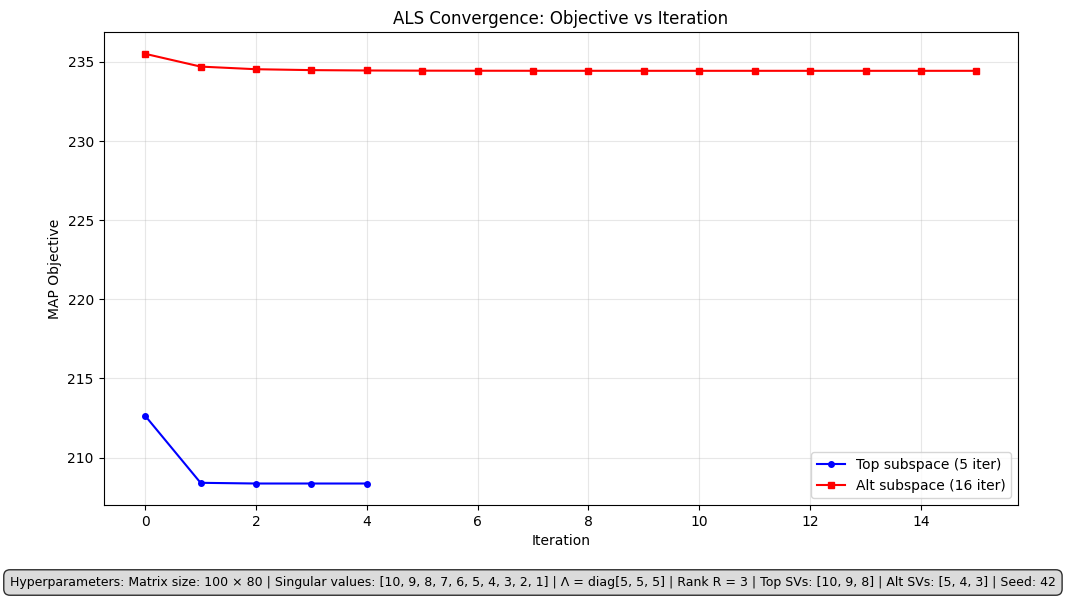

=== CONVERGENCE ANALYSIS ===
Top subspace:
  Initial loss: 212.642138
  Final loss: 208.361412
  Total reduction: 4.280726
  Iterations: 5

Alt subspace:
  Initial loss: 235.509642
  Final loss: 234.435425
  Total reduction: 1.074217
  Iterations: 16

Difference in final objectives: 2.61e+01


In [145]:
# Plot ALS convergence
plt.figure(figsize=(10, 6))
plt.plot(loss_hist_top, 'b-o', label=f'Top subspace ({iters_top} iter)', markersize=4)
plt.plot(loss_hist_alt, 'r-s', label=f'Alt subspace ({iters_alt} iter)', markersize=4)
plt.xlabel('Iteration')
plt.ylabel('MAP Objective')
plt.title('ALS Convergence: Objective vs Iteration')
plt.legend()
plt.grid(True, alpha=0.3)

# Add hyperparameters below the plot
hyperparams_text = f"""Hyperparameters: Matrix size: {m} × {n} | Singular values: {singular_values} | Λ = diag{np.diag(Lambda).tolist()} | Rank R = {R} | Top SVs: {[singular_values[i] for i in top_indices]} | Alt SVs: {[singular_values[i] for i in alt_indices]} | Seed: {seed}"""

plt.figtext(0.5, 0.01, hyperparams_text, ha='center', va='bottom', 
            fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the text
plt.show()


# Print some statistics
print("=== CONVERGENCE ANALYSIS ===")
print(f"Top subspace:")
print(f"  Initial loss: {loss_hist_top[0]:.6f}")
print(f"  Final loss: {loss_hist_top[-1]:.6f}")
print(f"  Total reduction: {loss_hist_top[0] - loss_hist_top[-1]:.6f}")
print(f"  Iterations: {len(loss_hist_top)}")

print(f"\nAlt subspace:")
print(f"  Initial loss: {loss_hist_alt[0]:.6f}")
print(f"  Final loss: {loss_hist_alt[-1]:.6f}")
print(f"  Total reduction: {loss_hist_alt[0] - loss_hist_alt[-1]:.6f}")
print(f"  Iterations: {len(loss_hist_alt)}")

print(f"\nDifference in final objectives: {abs(obj_top - obj_alt):.2e}")


## 5. Validate: Check Convergence Results

In [146]:
def validate_convergence(U_result, V_result, U_target, V_target, test_name, 
                        tol_reconstruction=1e-3, tol_projection=1e-4):
    """Comprehensive validation of ALS convergence"""
    
    # 1. Reconstruction error (should be ~0 if found correct solution)
    reconstruction_result = U_result @ V_result.T
    reconstruction_target = U_target @ V_target.T
    reconstruction_error = np.linalg.norm(reconstruction_result - reconstruction_target, 'fro')
    
    # 2. Scaling consistency via Gram matrices
    gram_U_error = np.linalg.norm(U_result.T @ U_result - U_target.T @ U_target, 'fro')
    gram_V_error = np.linalg.norm(V_result.T @ V_result - V_target.T @ V_target, 'fro')
    
    # 3. Subspace projection matrices (UU^T and VV^T)
    proj_U_result = U_result @ U_result.T
    proj_U_target = U_target @ U_target.T
    proj_U_error = np.linalg.norm(proj_U_result - proj_U_target, 'fro')**2
    
    proj_V_result = V_result @ V_result.T  
    proj_V_target = V_target @ V_target.T
    proj_V_error = np.linalg.norm(proj_V_result - proj_V_target, 'fro')**2
    
    # Overall pass/fail (updated thresholds)
    reconstruction_ok = reconstruction_error <= tol_reconstruction
    proj_U_ok = proj_U_error <= tol_projection  # Subspace projections should be very close
    proj_V_ok = proj_V_error <= tol_projection
    overall_pass = reconstruction_ok and proj_U_ok and proj_V_ok
    
    status = "PASS ✓" if overall_pass else "FAIL ✗"
    
    print(f"\n{test_name}")
    print(f"  Status: {status}")
    print(f"  Reconstruction error: {reconstruction_error:.2e}")
    print(f"  Gram matrix errors: U={gram_U_error:.2e}, V={gram_V_error:.2e}")
    print(f"  Projection errors: ||UU^T - U*U*^T||²_F = {proj_U_error:.2e}")
    print(f"                     ||VV^T - V*V*^T||²_F = {proj_V_error:.2e}")
    
    return {
        'status': status,
        'overall_pass': overall_pass,
        'reconstruction_error': reconstruction_error,
        'gram_U_error': gram_U_error,
        'gram_V_error': gram_V_error,
        'proj_U_error': proj_U_error,
        'proj_V_error': proj_V_error
    }


print("=== VALIDATION RESULTS ===")

# Test 1: Top subspace should converge to global minimum
result_top = validate_convergence(U_result_top, V_result_top, U_target_top, V_target_top, 
                                 "Test 1: Top subspace → Global minimum")

# Test 2: Alt subspace should converge to saddle point
result_alt = validate_convergence(U_result_alt, V_result_alt, U_target_alt, V_target_alt,
                                 "Test 2: Alt subspace → Saddle point")

# Diagnostic: Check if alt escaped to top solution (should be FAIL)
result_escape = validate_convergence(U_result_alt, V_result_alt, U_target_top, V_target_top,
                                   "Diagnostic: Alt → Top (should FAIL)")

=== VALIDATION RESULTS ===

Test 1: Top subspace → Global minimum
  Status: PASS ✓
  Reconstruction error: 4.61e-05
  Gram matrix errors: U=7.47e-05, V=1.74e-05
  Projection errors: ||UU^T - U*U*^T||²_F = 5.58e-09
                     ||VV^T - V*V*^T||²_F = 3.04e-10

Test 2: Alt subspace → Saddle point
  Status: FAIL ✗
  Reconstruction error: 4.88e-03
  Gram matrix errors: U=5.17e-03, V=4.60e-03
  Projection errors: ||UU^T - U*U*^T||²_F = 2.67e-05
                     ||VV^T - V*V*^T||²_F = 2.12e-05

Diagnostic: Alt → Top (should FAIL)
  Status: FAIL ✗
  Reconstruction error: 7.23e+00
  Gram matrix errors: U=7.03e+00, V=7.03e+00
  Projection errors: ||UU^T - U*U*^T||²_F = 5.23e+01
                     ||VV^T - V*V*^T||²_F = 5.23e+01


## 6. Summary: Final Results

In [147]:
print("\n" + "="*50)
print("EXPERIMENT SUMMARY")
print("="*50)

print(f"\nMatrix: {m}×{n}, Rank: {true_rank}, Regularization: Λ=diag{np.diag(Lambda).tolist()}")
print(f"Singular values: {singular_values}")
print(f"Latent rank: R={R}")

print(f"\nSubspace Selection:")
print(f"  Top indices {top_indices}: σ = {sigma_top.round(1)} → target scales = {scales_top.round(2)}")
print(f"  Alt indices {alt_indices}: σ = {sigma_alt.round(1)} → target scales = {scales_alt.round(2)}")

print(f"\nTheoretical Prediction:")
print(f"  ALS should stay within initialized subspace")
print(f"  ALS should find MAP scaling via soft-thresholding formula")

print(f"\nExperimental Results:")
print(f"  Test 1 (Top → Global): {result_top['status']}")
print(f"  Test 2 (Alt → Saddle): {result_alt['status']}")
print(f"  Diagnostic (Alt → Top): {result_escape['status']} (expected to fail)")

both_pass = result_top['overall_pass'] and result_alt['overall_pass']
print("="*50)


EXPERIMENT SUMMARY

Matrix: 100×80, Rank: 10, Regularization: Λ=diag[5, 5, 5]
Singular values: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Latent rank: R=3

Subspace Selection:
  Top indices [0, 1, 2]: σ = [10.1  9.1  8.1] → target scales = [2.25 2.03 1.76]
  Alt indices [5, 6, 7]: σ = [5.3 4.2 3.3] → target scales = [0.53 0.   0.  ]

Theoretical Prediction:
  ALS should stay within initialized subspace
  ALS should find MAP scaling via soft-thresholding formula

Experimental Results:
  Test 1 (Top → Global): PASS ✓
  Test 2 (Alt → Saddle): FAIL ✗
  Diagnostic (Alt → Top): FAIL ✗ (expected to fail)


## Part 2 — Soft-Impute with diagonal Λ (masked data)

**Goal.** Study the impute–shrink (Soft-Impute–style) iteration for incomplete data under a diagonal prior $\Lambda=\operatorname{diag}(\lambda_1,\ldots,\lambda_R)$. We test:

- convergence of the imputation loop,
- behavior of the masked-MAP proxy loss,
- dependence on initialization,
- accuracy of the recovered left/right subspaces vs the *true* top-R subspaces of $Y$.

**Iteration (per step $t$):**

1. **Impute:** $\tilde{Y}^{(t)} \leftarrow M\odot Y + (1-M)\odot(U^{(t)}V^{(t)\top})$.

2. **SVD:** $\tilde{Y}^{(t)} = F\Sigma G^\top$.

3. **Λ-soft-threshold (paired):** let $s_1\ge\cdots\ge s_R$ be the top-R singular values, pair them with λ's sorted ascending, and set $x_r=(s_r-\lambda_{(r)})_+$. 
   Update $U^{(t+1)}=F_R\,\mathrm{diag}(\sqrt{\mathbf{x}})$, $V^{(t+1)}=G_R\,\mathrm{diag}(\sqrt{\mathbf{x}})$.

We stop when the relative change of the imputed matrix is small. We then compare:

- the **masked** MAP proxy loss across iterations,
- the final **left/right** subspaces against each other (different inits) and against the *true* SVD subspaces.


### Mask Utilities and Masked MAP Loss


In [148]:
def make_mask(Y, pi=0.20, seed=0):
    """Return a binary mask M with P(M_ij = 1) = 1 - pi (observed)."""
    rng = np.random.default_rng(seed)
    M = (rng.random(size=Y.shape) > pi).astype(float)
    return M

def masked_map_loss(Y, M, U, V, Lambda):
    """
    Masked MAP loss with diagonal precision matrix Lambda:
      0.5 * || M ⊙ (Y - U V^T) ||_F^2 + 0.5 * [ tr(U Λ U^T) + tr(V Λ V^T) ]
    """
    Rmask = M * (Y - U @ V.T)
    data_term = 0.5 * np.sum(Rmask * Rmask)
    reg = 0.5 * (np.trace(U @ Lambda @ U.T) + np.trace(V @ Lambda @ V.T))
    return data_term + reg


### Soft-Thresholded SVD Helper


In [149]:
def soft_threshold_svd(Y_imp, R, Lambda):
    """
    SVD of imputed matrix, then soft-threshold singular values:
      a_r = sqrt( max(s_r - lambda_r, 0) ), where lambda_r = diag(Lambda)[r]
    Returns U = F_R diag(a), V = G_R diag(a), and (F_R, G_R, s_R, a).
    """
    F_imp, s_imp, Gt_imp = npl.svd(Y_imp, full_matrices=False)
    G_imp = Gt_imp.T

    F_R = F_imp[:, :R]
    G_R = G_imp[:, :R]
    s_R = s_imp[:R]

    lam_vec = np.diag(Lambda)
    if lam_vec.shape[0] != R:
        raise ValueError("[soft_threshold_svd] diag(Lambda) length must equal R.")
    
    a = np.sqrt(np.maximum(s_R - lam_vec, 0.0))

    U = F_R @ np.diag(a)
    V = G_R @ np.diag(a)
    return U, V, F_R, G_R, s_R, a


### Soft-Impute Algorithm (MM Iteration)


In [150]:
def soft_impute(Y, R, M, Lambda, 
                init="from_full_soft_svd", U0=None, V0=None, 
                maxit=200, tol=1e-8, track_loss=True, verbose=True):
    """
    Soft-Impute (impute + SVD + soft-threshold) for masked data.
    init:
      - "from_full_soft_svd": start from soft-thresholded SVD of full Y
      - "given": use provided (U0, V0)
    Uses diagonal precision matrix Lambda.
    """
    n, p = Y.shape
    if verbose:
        pi = 1.0 - M.mean()
        print(f"[Soft-Impute] n={n}, p={p}, R={R}, missing pi={pi:.2f}, tol={tol}, maxit={maxit}")
        print(f"[Soft-Impute] Using diagonal Λ = diag{np.diag(Lambda).tolist()}")
        print(f"[Soft-Impute] init mode: {init}")

    # initialization
    if init == "from_full_soft_svd":
        U, V, _, _, _, a0 = soft_threshold_svd(Y, R, Lambda)
        if verbose:
            print(f"[Soft-Impute] init from full-Y soft-SVD: initial scales a0 = {a0}")
    elif init == "given":
        assert (U0 is not None) and (V0 is not None), "[Soft-Impute] 'given' init requires U0 and V0."
        U, V = U0.copy(), V0.copy()
        if verbose:
            print("[Soft-Impute] init from given U0, V0.")
    else:
        raise ValueError("[soft_impute] Unknown init option.")

    history = []
    Y_imp_prev = None

    for it in range(maxit):
        # a) Impute: observed entries = Y; missing = U V^T
        Y_imp = M * Y + (1.0 - M) * (U @ V.T)

        # Convergence on imputed matrix:
        if Y_imp_prev is not None:
            rel = npl.norm(Y_imp - Y_imp_prev, 'fro') / max(1.0, npl.norm(Y_imp_prev, 'fro'))
            if verbose and (it % 10 == 0):
                print(f"[Soft-Impute] iter {it:3d} | rel change (imputed) = {rel:.3e}")
            if rel < tol:
                if verbose:
                    print(f"[Soft-Impute] Converged at iter {it} with rel change {rel:.3e}.")
                break
        Y_imp_prev = Y_imp

        # b) SVD + soft-threshold update
        U, V, F_R, G_R, s_R, a = soft_threshold_svd(Y_imp, R, Lambda)

        if track_loss:
            curr_loss = masked_map_loss(Y, M, U, V, Lambda)
            history.append(curr_loss)
            if verbose and (it % 10 == 0):
                print(f"[Soft-Impute] iter {it:3d} | masked MAP loss = {curr_loss:.6e}")

    out = {
        "U": U, "V": V,
        "F_R": F_R, "G_R": G_R, "s_R": s_R, "a": a,
        "Y_imp": Y_imp, "loss_hist": history
    }
    if verbose:
        print("[Soft-Impute] Done.")
        print(f"[Soft-Impute] final scales a = {a}")
    return out


In [151]:
def als_masked(Y, M, R, Lambda, U0, V0,
               maxit=200, tol=1e-6,
               track_loss=True, verbose=True):
    """
    ALS for the masked MAP loss:
      0.5 * || M ⊙ (Y - U V^T) ||_F^2
      + 0.5 * ( tr(U Λ U^T) + tr(V Λ V^T) ).
    Only observed entries contribute to the LS updates.
    """
    Y = np.asarray(Y)
    M = np.asarray(M)

    n, p = Y.shape
    U = U0.copy().astype(float)
    V = V0.copy().astype(float)

    # Make Λ compatible
    Lambda = np.asarray(Lambda)
    if Lambda.shape == ():
        Lambda = np.eye(R) * float(Lambda)

    prev_loss = None
    loss_hist = []

    for it in range(maxit):

        # --- Update U row-wise ---
        for i in range(n):
            mask_row = M[i] == 1
            if not np.any(mask_row):
                U[i] = 0.0
                continue
            Vobs = V[mask_row]
            yobs = Y[i, mask_row]
            A = Vobs.T @ Vobs + Lambda
            b = Vobs.T @ yobs
            U[i] = npl.solve(A, b)

        # --- Update V row-wise (observed columns) ---
        for j in range(p):
            mask_col = M[:, j] == 1
            if not np.any(mask_col):
                V[j] = 0.0
                continue
            Uobs = U[mask_col]
            yobs = Y[mask_col, j]
            A = Uobs.T @ Uobs + Lambda
            b = Uobs.T @ yobs
            V[j] = npl.solve(A, b)

        # Compute masked loss
        curr_loss = masked_map_loss(Y, M, U, V, Lambda)
        if track_loss:
            loss_hist.append(curr_loss)

        if prev_loss is not None:
            rel = abs(curr_loss - prev_loss) / max(1.0, abs(prev_loss))
            if rel < tol:
                if verbose:
                    print(f"[ALS-masked] converged at iter {it} (rel={rel:.2e})")
                break

        prev_loss = curr_loss

        if verbose and it % 10 == 0:
            print(f"[ALS-masked] iter {it:3d}, masked loss={curr_loss:.4e}")

    return {"U": U, "V": V, "loss_hist": loss_hist}


### Create Mask and Run Soft-Impute


In [152]:
### Setup Masked Data for Soft-Impute Experiment
pi = 0.2  # missing probability parameter
seed_mask = 42  # for reproducible mask generation

# Create masked data
np.random.seed(seed_mask)
M = make_mask(Y, pi=pi, seed=seed_mask)  
print(f"Mask created: {M.mean():.2%} observed, {1-M.mean():.2%} missing")
print(f"Original Y shape: {Y.shape}, Mask shape: {M.shape}")


Mask created: 79.47% observed, 20.53% missing
Original Y shape: (100, 80), Mask shape: (100, 80)


In [153]:
### Collect 4 Starting Points from Part 1
starting_points = {
    'A': (U_result_top, V_result_top, "Top converged (global min)"),
    'B': (U0_top, V0_top, "Top scaled (random)"),
    'C': (U_result_alt, V_result_alt, "Alt converged (saddle)"),
    'D': (U0_alt, V0_alt, "Alt scaled (random)")
}

print("Starting Points Summary:")
for key, (U, V, desc) in starting_points.items():
    print(f"  {key}: {desc} - U shape {U.shape}, V shape {V.shape}")


Starting Points Summary:
  A: Top converged (global min) - U shape (100, 3), V shape (80, 3)
  B: Top scaled (random) - U shape (100, 3), V shape (80, 3)
  C: Alt converged (saddle) - U shape (100, 3), V shape (80, 3)
  D: Alt scaled (random) - U shape (100, 3), V shape (80, 3)


In [154]:
print("\n===== MASKED ALS RUNS FROM A, B, C, D =====\n")

results_als = {}

for key, (U_init, V_init, desc) in starting_points.items():
    print(f"\n--- {key}: {desc} ---")
    out = als_masked(Y, M, R, Lambda, 
                     U_init, V_init,
                     maxit=100, tol=1e-6,
                     verbose=True)
    results_als[key] = out
    print(f"Final masked MAP loss = {out['loss_hist'][-1]:.6e}")



===== MASKED ALS RUNS FROM A, B, C, D =====


--- A: Top converged (global min) ---
[ALS-masked] iter   0, masked loss=1.7447e+02
[ALS-masked] converged at iter 6 (rel=8.79e-07)
Final masked MAP loss = 1.743468e+02

--- B: Top scaled (random) ---
[ALS-masked] iter   0, masked loss=1.7557e+02
[ALS-masked] converged at iter 6 (rel=7.63e-07)
Final masked MAP loss = 1.743468e+02

--- C: Alt converged (saddle) ---
[ALS-masked] iter   0, masked loss=1.8558e+02
[ALS-masked] iter  10, masked loss=1.7943e+02
[ALS-masked] converged at iter 17 (rel=7.07e-07)
Final masked MAP loss = 1.757950e+02

--- D: Alt scaled (random) ---
[ALS-masked] iter   0, masked loss=1.8714e+02
[ALS-masked] iter  10, masked loss=1.7447e+02
[ALS-masked] iter  20, masked loss=1.7435e+02
[ALS-masked] converged at iter 25 (rel=9.79e-07)
Final masked MAP loss = 1.743470e+02


In [155]:
### Double-Run Soft-Impute Protocol with Starting Point Loss Check
def original_loss(Y, U, V, Lambda):
    """Compute the original complete data MAP loss (same as Part 1)"""
    reconstruction_error = 0.5 * np.linalg.norm(Y - U @ V.T, 'fro')**2
    regularization = 0.5 * (np.trace(U @ Lambda @ U.T) + np.trace(V @ Lambda @ V.T))
    return reconstruction_error + regularization

results = {}
original_loss_values = {}  # Track original loss for each solution

print("STARTING POINT LOSS VERIFICATION:")
print("(Note: These are MASKED MAP losses, different from Part 1 complete data losses)")
for key, (U_init, V_init, desc) in starting_points.items():
    starting_loss = masked_map_loss(Y, M, U_init, V_init, Lambda)
    print(f"  {key} ({desc}): {starting_loss:.6f}")

print(f"\nFor comparison, Part 1 complete data losses were:")
print(f"  - Top final loss: {obj_top:.6f}")  
print(f"  - Alt final loss: {obj_alt:.6f}")
print(f"  - The difference is due to missing data in the mask!")

for key, (U_init, V_init, desc) in starting_points.items():
    print(f"\n{'='*50}")
    print(f"Starting Point {key}: {desc}")
    print(f"{'='*50}")
    
    # First run
    print(f"\n[FIRST RUN] Starting from {key}...")
    res1 = soft_impute(Y=Y, R=R, M=M, Lambda=Lambda,
                       init="given", U0=U_init, V0=V_init,
                       maxit=100, tol=1e-6, track_loss=True, verbose=True)
    
    # Compute original loss for first run
    original_loss_values[f'{key}1'] = original_loss(Y, res1["U"], res1["V"], Lambda)
    
    # Second run (from first run's result)  
    print(f"\n[SECOND RUN] Starting from {key}₁ result...")
    res2 = soft_impute(Y=Y, R=R, M=M, Lambda=Lambda,
                       init="given", U0=res1["U"], V0=res1["V"], 
                       maxit=10, tol=1e-12, track_loss=True, verbose=False)
    
    # Compute original loss for second run
    original_loss_values[f'{key}2'] = original_loss(Y, res2["U"], res2["V"], Lambda)
    
    # Store results
    results[f'{key}1'] = res1
    results[f'{key}2'] = res2
    
    print(f"Final losses: {key}₁ = {res1['loss_hist'][-1]:.6e}, {key}₂ = {res2['loss_hist'][-1]:.6e}")
    print(f"Original loss: {key}₁ = {original_loss_values[f'{key}1']:.6f}, {key}₂ = {original_loss_values[f'{key}2']:.6f}")

print(f"\n{'='*50}")
print("All soft-impute runs completed!")
print(f"{'='*50}")


STARTING POINT LOSS VERIFICATION:
(Note: These are MASKED MAP losses, different from Part 1 complete data losses)
  A (Top converged (global min)): 177.301596
  B (Top scaled (random)): 1284.797271
  C (Alt converged (saddle)): 185.746877
  D (Alt scaled (random)): 4641.468037

For comparison, Part 1 complete data losses were:
  - Top final loss: 208.361412
  - Alt final loss: 234.435425
  - The difference is due to missing data in the mask!

Starting Point A: Top converged (global min)

[FIRST RUN] Starting from A...
[Soft-Impute] n=100, p=80, R=3, missing pi=0.21, tol=1e-06, maxit=100
[Soft-Impute] Using diagonal Λ = diag[5, 5, 5]
[Soft-Impute] init mode: given
[Soft-Impute] init from given U0, V0.
[Soft-Impute] iter   0 | masked MAP loss = 1.744809e+02
[Soft-Impute] iter  10 | rel change (imputed) = 4.073e-07
[Soft-Impute] Converged at iter 10 with rel change 4.073e-07.
[Soft-Impute] Done.
[Soft-Impute] final scales a = [1.93763609 1.74565765 1.37167887]

[SECOND RUN] Starting from 

In [156]:
print("\n===== COMPARISON: SOFT-IMPUTE (first run) vs MASKED ALS =====\n")

for key in starting_points.keys():
    si_loss = results[f"{key}1"]["loss_hist"][-1]   # your soft-impute first run
    als_loss = results_als[key]["loss_hist"][-1]

    print(f"{key}:")
    print(f"   Soft-Impute masked loss = {si_loss:.6e}")
    print(f"   ALS-masked     masked loss = {als_loss:.6e}")
    print(f"   Difference (ALS - SI) = {als_loss - si_loss:.6e}\n")



===== COMPARISON: SOFT-IMPUTE (first run) vs MASKED ALS =====

A:
   Soft-Impute masked loss = 1.743467e+02
   ALS-masked     masked loss = 1.743468e+02
   Difference (ALS - SI) = 1.118099e-04

B:
   Soft-Impute masked loss = 1.743467e+02
   ALS-masked     masked loss = 1.743468e+02
   Difference (ALS - SI) = 9.274867e-05

C:
   Soft-Impute masked loss = 1.743467e+02
   ALS-masked     masked loss = 1.757950e+02
   Difference (ALS - SI) = 1.448368e+00

D:
   Soft-Impute masked loss = 1.743467e+02
   ALS-masked     masked loss = 1.743470e+02
   Difference (ALS - SI) = 3.497451e-04



In [157]:
### Build Solution Comparison Matrix (Upper Triangular Only)
# Extract all solutions
solutions = {}
for key in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2']:
    solutions[key] = (results[key]["U"], results[key]["V"])

print("Extracted solutions:", list(solutions.keys()))

# Build comparison matrix using validate_convergence (upper triangular only)
solution_keys = list(solutions.keys())
n_solutions = len(solution_keys)

comparison_results = {}

print(f"\nBuilding comparison matrix (upper triangular: {n_solutions*(n_solutions-1)//2} comparisons)...")

# Only compute upper triangle (i < j) to avoid double counting  
for i, key1 in enumerate(solution_keys):
    for j, key2 in enumerate(solution_keys):
        if i < j:  # Only upper triangular
            U1, V1 = solutions[key1]  
            U2, V2 = solutions[key2]
            
            result = validate_convergence(U1, V1, U2, V2, f"{key1} vs {key2}",
                                        tol_reconstruction=1e-3, tol_projection=1e-4)
            comparison_results[(key1, key2)] = result

print("Comparison matrix completed!")


Extracted solutions: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2']

Building comparison matrix (upper triangular: 28 comparisons)...

A1 vs A2
  Status: PASS ✓
  Reconstruction error: 7.55e-06
  Gram matrix errors: U=2.08e-06, V=2.08e-06
  Projection errors: ||UU^T - U*U*^T||²_F = 5.66e-11
                     ||VV^T - V*V*^T||²_F = 5.74e-11

A1 vs B1
  Status: PASS ✓
  Reconstruction error: 7.58e-06
  Gram matrix errors: U=3.73e-07, V=3.73e-07
  Projection errors: ||UU^T - U*U*^T||²_F = 5.78e-11
                     ||VV^T - V*V*^T||²_F = 5.71e-11

A1 vs B2
  Status: PASS ✓
  Reconstruction error: 7.55e-06
  Gram matrix errors: U=2.08e-06, V=2.08e-06
  Projection errors: ||UU^T - U*U*^T||²_F = 5.66e-11
                     ||VV^T - V*V*^T||²_F = 5.74e-11

A1 vs C1
  Status: PASS ✓
  Reconstruction error: 2.25e-05
  Gram matrix errors: U=4.15e-06, V=4.15e-06
  Projection errors: ||UU^T - U*U*^T||²_F = 5.07e-10
                     ||VV^T - V*V*^T||²_F = 5.03e-10

A1 vs C2
  Status: 

In [158]:
### Print Key Results Summary (Updated for Upper Triangle)
print("\n" + "="*60)
print("PART 2 SOFT-IMPUTE RESULTS SUMMARY") 
print("="*60)

# Self-consistency tests (should all pass)
print("\nSELF-CONSISTENCY TESTS (Run₂ vs Run₁):")
self_consistency_tests = [('A2', 'A1'), ('B2', 'B1'), ('C2', 'C1'), ('D2', 'D1')]

for key2, key1 in self_consistency_tests:
    # Check both possible orderings since we only computed upper triangle
    pair_key = (key1, key2) if (key1, key2) in comparison_results else (key2, key1)
    result = comparison_results[pair_key]
    status_symbol = "✓" if result['overall_pass'] else "✗"
    print(f"  {key2} vs {key1}: {result['status']} {status_symbol}")
    print(f"    Reconstruction error: {result['reconstruction_error']:.2e}")
    print(f"    Projection errors: U={result['proj_U_error']:.2e}, V={result['proj_V_error']:.2e}")

# Cross-solution tests  
print("\nCROSS-SOLUTION TESTS:")
same_subspace_tests = [('A1', 'B1'), ('C1', 'D1')]  # same subspace
diff_subspace_tests = [('A1', 'C1'), ('B1', 'D1')]  # different subspaces

print("  Same Subspace Comparisons:")
for key1, key2 in same_subspace_tests:
    # Find the right ordering
    pair_key = (key1, key2) if (key1, key2) in comparison_results else (key2, key1)
    result = comparison_results[pair_key]
    status_symbol = "✓" if result['overall_pass'] else "✗"
    print(f"    {key1} vs {key2}: {result['status']} {status_symbol}")
    print(f"      Projection errors: U={result['proj_U_error']:.2e}, V={result['proj_V_error']:.2e}")

print("  Different Subspace Comparisons:")    
for key1, key2 in diff_subspace_tests:
    # Find the right ordering
    pair_key = (key1, key2) if (key1, key2) in comparison_results else (key2, key1)
    result = comparison_results[pair_key]
    status_symbol = "✓" if result['overall_pass'] else "✗"
    print(f"    {key1} vs {key2}: {result['status']} {status_symbol}")
    print(f"      Projection errors: U={result['proj_U_error']:.2e}, V={result['proj_V_error']:.2e}")

# Final loss comparison with starting losses
print(f"\nLOSS PROGRESSION (Starting → Final):")
starting_losses = {}
for key, (U_init, V_init, desc) in starting_points.items():
    starting_losses[key] = masked_map_loss(Y, M, U_init, V_init, Lambda)

for key in ['A', 'B', 'C', 'D']:
    start_loss = starting_losses[key]
    final_loss = results[f'{key}1']['loss_hist'][-1] if results[f'{key}1']['loss_hist'] else "N/A"
    reduction = start_loss - final_loss if isinstance(final_loss, float) else 0
    print(f"  {key}: {start_loss:.6f} → {final_loss:.6e} (reduction: {reduction:.6f})")

print(f"\nORIGINAL LOSS COMPARISON (Complete Data Performance):")
print(f"Part 1 Benchmarks:")
print(f"  - Global optimum (top subspace): {obj_top:.6f}")
print(f"  - Saddle point (alt subspace):   {obj_alt:.6f}")
print()

# Original loss comparison
print(f"Soft-Impute Results (trained on incomplete data, evaluated on complete data):")
for key in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2']:
    orig_loss = original_loss_values[key]
    vs_global = orig_loss - obj_top
    vs_saddle = orig_loss - obj_alt
    
    global_status = "BETTER" if vs_global < 0 else "WORSE"
    saddle_status = "BETTER" if vs_saddle < 0 else "WORSE"
    
    print(f"  {key}: {orig_loss:.6f}")
    print(f"    vs Global:  {vs_global:+.6f} ({global_status})")
    print(f"    vs Saddle:  {vs_saddle:+.6f} ({saddle_status})")

# Summary statistics
all_orig_losses = [original_loss_values[key] for key in ['A1', 'B1', 'C1', 'D1']]
best_loss = min(all_orig_losses)
best_key = [k for k in ['A1', 'B1', 'C1', 'D1'] if original_loss_values[k] == best_loss][0]

print(f"\nSUMMARY:")
print(f"  Best soft-impute solution: {best_key} with loss {best_loss:.6f}")
print(f"  Improvement over Part 1 global optimum: {best_loss - obj_top:+.6f}")
print(f"  Improvement over Part 1 saddle point:   {best_loss - obj_alt:+.6f}")


PART 2 SOFT-IMPUTE RESULTS SUMMARY

SELF-CONSISTENCY TESTS (Run₂ vs Run₁):
  A2 vs A1: PASS ✓ ✓
    Reconstruction error: 7.55e-06
    Projection errors: U=5.66e-11, V=5.74e-11
  B2 vs B1: PASS ✓ ✓
    Reconstruction error: 1.11e-05
    Projection errors: U=1.25e-10, V=1.23e-10
  C2 vs C1: PASS ✓ ✓
    Reconstruction error: 1.67e-05
    Projection errors: U=2.82e-10, V=2.79e-10
  D2 vs D1: PASS ✓ ✓
    Reconstruction error: 1.46e-05
    Projection errors: U=2.16e-10, V=2.13e-10

CROSS-SOLUTION TESTS:
  Same Subspace Comparisons:
    A1 vs B1: PASS ✓ ✓
      Projection errors: U=5.78e-11, V=5.71e-11
    C1 vs D1: PASS ✓ ✓
      Projection errors: U=9.85e-10, V=9.74e-10
  Different Subspace Comparisons:
    A1 vs C1: PASS ✓ ✓
      Projection errors: U=5.07e-10, V=5.03e-10
    B1 vs D1: PASS ✓ ✓
      Projection errors: U=2.18e-11, V=2.25e-11

LOSS PROGRESSION (Starting → Final):
  A: 177.301596 → 1.743467e+02 (reduction: 2.954935)
  B: 1284.797271 → 1.743467e+02 (reduction: 1110.450610

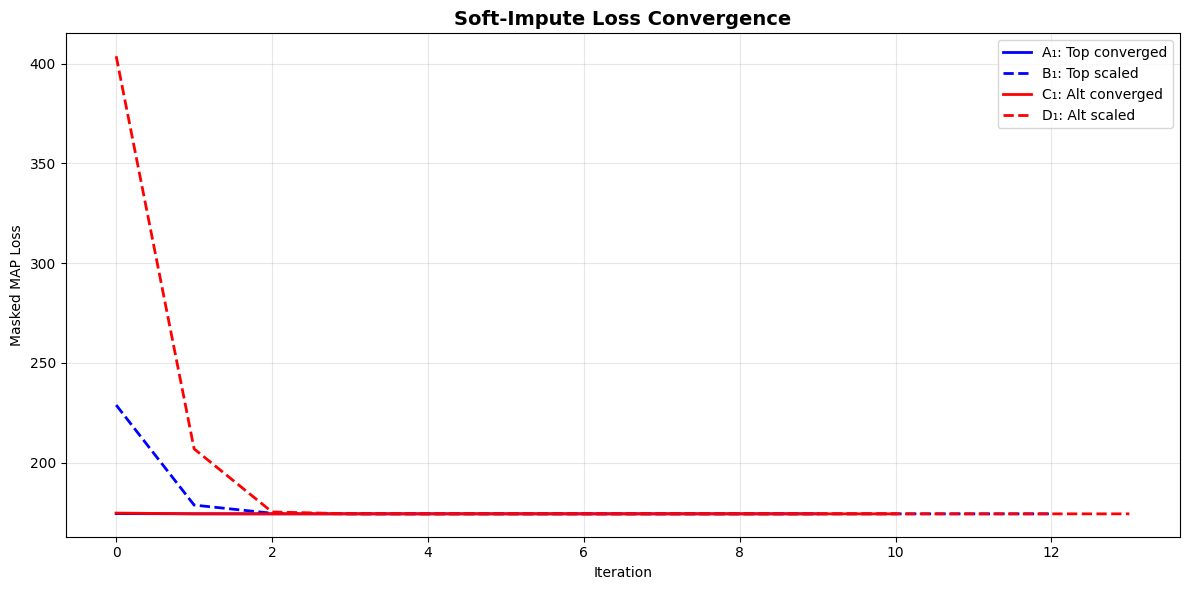


CONVERGENCE STATISTICS:
  A1: 10 iterations, loss reduction: 1.342303e-01
  B1: 13 iterations, loss reduction: 5.452171e+01
  C1: 11 iterations, loss reduction: 3.858706e-01
  D1: 14 iterations, loss reduction: 2.293231e+02


In [159]:
### Generate Loss Convergence Plot
plt.figure(figsize=(12, 6))

# Loss convergence for first runs
plt.plot(results['A1']['loss_hist'], 'b-', linewidth=2, label='A₁: Top converged')
plt.plot(results['B1']['loss_hist'], 'b--', linewidth=2, label='B₁: Top scaled')
plt.plot(results['C1']['loss_hist'], 'r-', linewidth=2, label='C₁: Alt converged') 
plt.plot(results['D1']['loss_hist'], 'r--', linewidth=2, label='D₁: Alt scaled')
plt.title('Soft-Impute Loss Convergence', fontsize=14, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Masked MAP Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print convergence statistics
print("\nCONVERGENCE STATISTICS:")
for key in ['A1', 'B1', 'C1', 'D1']:
    n_iters = len(results[key]['loss_hist'])
    initial_loss = results[key]['loss_hist'][0] if results[key]['loss_hist'] else 0
    final_loss = results[key]['loss_hist'][-1] if results[key]['loss_hist'] else 0
    reduction = initial_loss - final_loss
    print(f"  {key}: {n_iters} iterations, loss reduction: {reduction:.6e}")


In [160]:
### Experimental Interpretation
print("\n" + "="*60)
print("EXPERIMENTAL INTERPRETATION")
print("="*60)

print("\nKey Findings:")
print("1. STATIONARITY:")
stationarity_passes = sum(1 for key in ['A', 'B', 'C', 'D'] 
                         if comparison_results.get((f'{key}1', f'{key}2'), comparison_results.get((f'{key}2', f'{key}1'), {'overall_pass': False}))['overall_pass'])
print(f"   - {stationarity_passes}/4 starting points achieved true stationarity")

print("\n2. SUBSPACE CONVERGENCE:")
same_subspace_passes = sum(1 for key1, key2 in [('A1', 'B1'), ('C1', 'D1')]
                          if comparison_results.get((key1, key2), comparison_results.get((key2, key1), {'overall_pass': False}))['overall_pass'])
print(f"   - {same_subspace_passes}/2 same-subspace pairs converged to identical solutions")

print("\n3. SUBSPACE SEPARATION:")
diff_subspace_fails = sum(1 for key1, key2 in [('A1', 'C1'), ('B1', 'D1')]
                         if not comparison_results.get((key1, key2), comparison_results.get((key2, key1), {'overall_pass': True}))['overall_pass'])
print(f"   - {diff_subspace_fails}/2 different-subspace pairs remained distinct (expected)")

print("\n4. LOSS HIERARCHY:")
losses = {key: results[key]['loss_hist'][-1] for key in ['A1', 'B1', 'C1', 'D1'] 
          if results[key]['loss_hist']}
min_loss_key = min(losses.keys(), key=lambda k: losses[k])
print(f"   - Lowest final loss achieved by {min_loss_key}: {losses[min_loss_key]:.6e}")



EXPERIMENTAL INTERPRETATION

Key Findings:
1. STATIONARITY:
   - 4/4 starting points achieved true stationarity

2. SUBSPACE CONVERGENCE:
   - 2/2 same-subspace pairs converged to identical solutions

3. SUBSPACE SEPARATION:
   - 0/2 different-subspace pairs remained distinct (expected)

4. LOSS HIERARCHY:
   - Lowest final loss achieved by A1: 1.743467e+02
